### 1. Environment Setup & Data Loading

##### 1.1 Pips

In [1]:
#!pip install holidays

##### 1.2 Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays 
#RANDOM_STATE = 42

##### 1.3 Load Data

In [3]:
adir=1
if(adir==1):
    raw_data = pd.read_csv(r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data\data.csv")
else:
    raw_data = pd.read_csv(r"C:\Users\97252\Desktop\Chen_proj\data\data.csv")

raw_data.head(3)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,231974218,08/09/2021,01:06:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1006343,234270,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,177934247,04/07/2018,19:48:00,BROOKLYN,NaN,79,0.0,NaN,NaN,True,...,M,WHITE HISPANIC,25-44,M,BLACK,1000082.937500000000000,189064.671875000000000,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,255028563,12/02/2022,22:57:00,BRONX,OUTSIDE,47,0.0,STREET,GROCERY/BODEGA,False,...,(null),(null),25-44,M,BLACK,1020691,257125,40.872349,-73.868233,POINT (-73.868233 40.872349)


### 2. Initial Data Assessment & Type Handling

In [4]:
raw_data.shape

(29744, 21)

##### 2.1 Data Types

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29744 entries, 0 to 29743
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             29744 non-null  int64  
 1   OCCUR_DATE               29744 non-null  object 
 2   OCCUR_TIME               29744 non-null  object 
 3   BORO                     29744 non-null  object 
 4   LOC_OF_OCCUR_DESC        4148 non-null   object 
 5   PRECINCT                 29744 non-null  int64  
 6   JURISDICTION_CODE        29742 non-null  float64
 7   LOC_CLASSFCTN_DESC       4148 non-null   object 
 8   LOCATION_DESC            14767 non-null  object 
 9   STATISTICAL_MURDER_FLAG  29744 non-null  bool   
 10  PERP_AGE_GROUP           20400 non-null  object 
 11  PERP_SEX                 20434 non-null  object 
 12  PERP_RACE                20434 non-null  object 
 13  VIC_AGE_GROUP            29744 non-null  object 
 14  VIC_SEX               

In [6]:
# Convert date and time columns
raw_data['OCCUR_DATE'] = pd.to_datetime(raw_data['OCCUR_DATE'], format='%m/%d/%Y')
raw_data['OCCUR_TIME'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S').dt.time

# Convert integer and boolean types
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('Int64')
raw_data['STATISTICAL_MURDER_FLAG'] = raw_data['STATISTICAL_MURDER_FLAG'].astype(bool)

# Convert categorical columns
categorical_cols = ['BORO', 'PERP_SEX','PERP_RACE', 'PERP_AGE_GROUP',
'VIC_SEX', 'VIC_RACE', 'VIC_AGE_GROUP','LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC','PRECINCT']

for col in categorical_cols:
    raw_data[col] = raw_data[col].astype('category')

# Remove commas from coordinates (handle as string first)
raw_data['X_COORD_CD'] = raw_data['X_COORD_CD'].astype(str).str.replace(',', '')
raw_data['Y_COORD_CD'] = raw_data['Y_COORD_CD'].astype(str).str.replace(',', '')

# Convert to float
raw_data['X_COORD_CD'] = pd.to_numeric(raw_data['X_COORD_CD'], errors='coerce')
raw_data['Y_COORD_CD'] = pd.to_numeric(raw_data['Y_COORD_CD'], errors='coerce')

In [7]:
raw_data.dtypes

INCIDENT_KEY                        int64
OCCUR_DATE                 datetime64[ns]
OCCUR_TIME                         object
BORO                             category
LOC_OF_OCCUR_DESC                category
PRECINCT                         category
JURISDICTION_CODE                   Int64
LOC_CLASSFCTN_DESC               category
LOCATION_DESC                    category
STATISTICAL_MURDER_FLAG              bool
PERP_AGE_GROUP                   category
PERP_SEX                         category
PERP_RACE                        category
VIC_AGE_GROUP                    category
VIC_SEX                          category
VIC_RACE                         category
X_COORD_CD                        float64
Y_COORD_CD                        float64
Latitude                          float64
Longitude                         float64
Lon_Lat                            object
dtype: object

In [8]:
# Check the type of the first element in the column
print(type(raw_data['OCCUR_TIME'].iloc[0]))

<class 'datetime.time'>


##### 2.2 Duplicate Rows

In [9]:
raw_data.duplicated().sum()

np.int64(0)

### 3. Technical Cleanup (Column Level)

In [10]:
raw_data.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'Lon_Lat'],
      dtype='object')

##### 3.1 Define Target Variable

In [11]:
source_col = 'STATISTICAL_MURDER_FLAG'
target_col = 'is_murder'

# Check if the source column exists to prevent errors on re-runs
if source_col in raw_data.columns:
    # 1. Convert Boolean (True/False) to Integer (1/0)
    raw_data[target_col] = raw_data[source_col].astype(int)
    print(f"Created target column '{target_col}' (1=Murder, 0=Non-Fatal).")

    # 2. Drop the original column 
    raw_data.drop(columns=[source_col], inplace=True)
    print(f"Dropped original column '{source_col}' to prevent leakage.")

else:
    print(f"Column '{source_col}' not found (likely already dropped).")

# Verify the distribution of the new target variable
print(f"\nTarget Distribution ({target_col}):")
print(raw_data[target_col].value_counts())

Created target column 'is_murder' (1=Murder, 0=Non-Fatal).
Dropped original column 'STATISTICAL_MURDER_FLAG' to prevent leakage.

Target Distribution (is_murder):
is_murder
0    23979
1     5765
Name: count, dtype: int64


##### 3.2 Drop Irrelevant Columns

In [12]:
# -------------------------------------------------------
# Drop INCIDENT_KEY (Unique Identifier)
# -------------------------------------------------------

# Reason: High cardinality feature with no predictive power.
# Keeping it leads to overfitting (memorization).
if 'INCIDENT_KEY' in raw_data.columns:
    raw_data.drop(columns=['INCIDENT_KEY'], inplace=True)
    print("Dropped 'INCIDENT_KEY' successfully.")
else:
    print("INCIDENT_KEY' not found (already dropped).")

Dropped 'INCIDENT_KEY' successfully.


In [13]:
# -------------------------------------------------------
# Investigate & Drop JURISDICTION_CODE
# -------------------------------------------------------

col_name = 'JURISDICTION_CODE'

if col_name in raw_data.columns:
    print(f"--- Investigating {col_name} ---")
    
    # 1. Show the distribution to justify dropping it
    # 0 = Patrol, 1 = Transit, 2 = Housing
    distribution = raw_data[col_name].value_counts(normalize=True)
    print("Value Distribution (Percentage):")
    print(distribution)
    
    # 2. Check if variance is too low (e.g., > 95% is the same value)
    top_val_pct = distribution.iloc[0]
    
    if top_val_pct > 0.95:
        print(f"Low Variance Detected: {top_val_pct:.1%} of data is '{distribution.index[0]}'.")
        raw_data.drop(columns=[col_name], inplace=True)
        print(f"Dropped '{col_name}' due to lack of predictive signal.")
    else:
        print(f"Column kept (Variance seems okay).")
        
else:
    print(f"{col_name}' not found (already dropped).")

--- Investigating JURISDICTION_CODE ---
Value Distribution (Percentage):
JURISDICTION_CODE
0    0.839116
2    0.157219
1    0.003665
Name: proportion, dtype: Float64
Column kept (Variance seems okay).


In [14]:
# List of location-related columns
raw_data[['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat']].head(3)

,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,1.006343e+06,234270.000000,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,1.000083e+06,189064.671875,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,1.020691e+06,257125.000000,40.872349,-73.868233,POINT (-73.868233 40.872349)


Correlation Matrix between coordinate systems:
            X_COORD_CD  Y_COORD_CD  Latitude  Longitude
X_COORD_CD    1.000000    0.138514  0.137934   0.999998
Y_COORD_CD    0.138514    1.000000  1.000000   0.140439
Latitude      0.137934    1.000000  1.000000   0.139860
Longitude     0.999998    0.140439  0.139860   1.000000


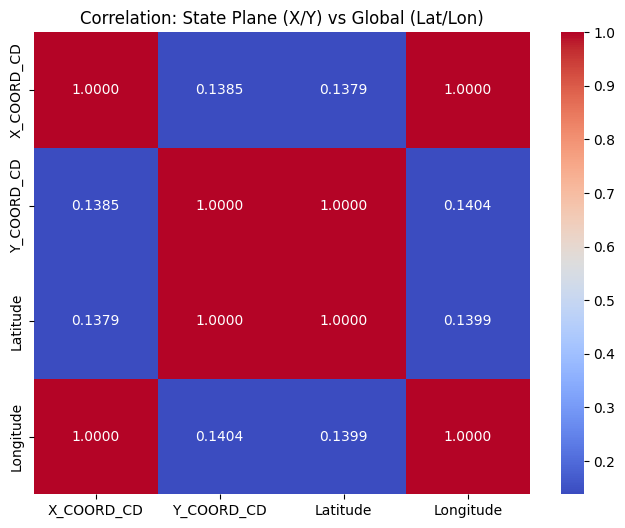


Sample comparison for 'Lon_Lat':
    Latitude  Longitude                                        Lon_Lat
0  40.809673 -73.920193   POINT (-73.92019278899994 40.80967347200004)
1  40.685610 -73.942913  POINT (-73.94291302299996 40.685609672000055)
2  40.872349 -73.868233                   POINT (-73.868233 40.872349)
3  40.642490 -73.996912  POINT (-73.99691224999998 40.642489932000046)
4  40.845984 -73.907461   POINT (-73.90746098599993 40.84598358900007)

Example value in 'Lon_Lat': POINT (-73.92019278899994 40.80967347200004)
Observation: If this value matches the Latitude/Longitude columns, 'Lon_Lat' can be dropped.


In [15]:
# 1. Check Correlation between coordinate systems
# X_COORD_CD and Y_COORD_CD represent the local projection (NY State Plane).
# Latitude and Longitude represent the global projection (WGS 1984).
# We expect a near-perfect correlation (close to 1.0 or -1.0) between them.
location_numeric = raw_data[['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']].dropna()

# Calculate the correlation matrix
corr_matrix = location_numeric.corr()

print("Correlation Matrix between coordinate systems:")
print(corr_matrix)

# Visualization of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation: State Plane (X/Y) vs Global (Lat/Lon)")
plt.show()

# 2. Inspect the 'Lon_Lat' column
# We need to verify if this column is redundant (e.g., just a string combination of Lat/Lon).
# This is often used for visualization tools but is not useful for ML models as a string.
print("\nSample comparison for 'Lon_Lat':")
print(raw_data[['Latitude', 'Longitude', 'Lon_Lat']].head())

# Check a single value to understand the format (e.g., "POINT (-73.9 40.8)")
if not raw_data['Lon_Lat'].dropna().empty:
    sample_val = raw_data['Lon_Lat'].dropna().iloc[0]
    print(f"\nExample value in 'Lon_Lat': {sample_val}")
    print("Observation: If this value matches the Latitude/Longitude columns, 'Lon_Lat' can be dropped.")

In [16]:
# Based on the correlation analysis and data inspection:
# 1. 'X_COORD_CD' and 'Y_COORD_CD' have a perfect correlation (~1.0) with Longitude/Latitude.
#    Keeping them would introduce multicollinearity without adding new information.
# 2. 'Lon_Lat' is a string representation ("POINT (...)") of the coordinates we already have.
#    Machine learning models cannot process this text format directly.

cols_to_drop_location = ['X_COORD_CD', 'Y_COORD_CD', 'Lon_Lat']

# Drop the redundant location columns
raw_data.drop(columns=cols_to_drop_location, inplace=True, errors='ignore')

# Verify that we are left with only the clean coordinate columns
print(f"Remaining location columns: {[col for col in raw_data.columns if col in ['Latitude', 'Longitude']]}")

Remaining location columns: ['Latitude', 'Longitude']


### 4. Domain-Specific Sanity Checks & Logic

##### 4.1 Logic Validation - Category

In [17]:
# 1. Perpetrator Columns
perp_cols = [
    'PERP_AGE_GROUP', 
    'PERP_SEX', 
    'PERP_RACE'
]

large_perp_cols = []

print("--- 🕵️ Inspecting PERPETRATOR Columns (<= 15 Values) ---")

for col in perp_cols:
    if col in raw_data.columns:
        unique_vals = raw_data[col].unique()
        n_unique = len(unique_vals)
        
        # Filter condition: only small groups
        if n_unique <= 15:
            print(f"\n🔹 Column: {col} ({n_unique} values)")
            
            # Sort and print
            try:
                sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
                print(f"   Values: {sorted_vals}")
            except:
                print(f"   Values: {unique_vals.tolist()}")
            
            # Check for missing values
            nans = raw_data[col].isnull().sum()
            if nans > 0:
                print(f"   ⚠️ Contains {nans} NANs")
            
            print("-" * 40)
            
        else:
            large_perp_cols.append(f"{col} ({n_unique} values)")

# Summary for handling in the next step
if large_perp_cols:
    print("\n" + "="*40)
    print("--- ⏳ Large Perp Columns Saved for Next Step ---")
    for col in large_perp_cols:
        print(f"🔸 {col}")
    print("="*40)
else:
    print("\n✅ All Perp columns were small enough to display.")

--- 🕵️ Inspecting PERPETRATOR Columns (<= 15 Values) ---

🔹 Column: PERP_AGE_GROUP (13 values)
   Values: ['(null)', '1020', '1028', '18-24', '2021', '224', '25-44', '45-64', '65+', '940', '<18', 'UNKNOWN', nan]
   ⚠️ Contains 9344 NANs
----------------------------------------

🔹 Column: PERP_SEX (5 values)
   Values: ['(null)', 'F', 'M', 'U', nan]
   ⚠️ Contains 9310 NANs
----------------------------------------

🔹 Column: PERP_RACE (9 values)
   Values: ['(null)', 'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC', nan]
   ⚠️ Contains 9310 NANs
----------------------------------------

✅ All Perp columns were small enough to display.


##### 4.2.1 Hypothesis Verification: Structural Missingness in Suspect Data
**Hypothesis:** Missing values in Perpetrator columns (`PERP_SEX`, `PERP_RACE`, `PERP_AGE_GROUP`) are not random data entry errors. Instead, they represent a specific real-world event: **The suspect was not identified or caught.**

**Method:** We will check for correlation between missing/garbage values across these three columns. If a row has missing info in one column, we expect it to be missing in all three (High Overlap).

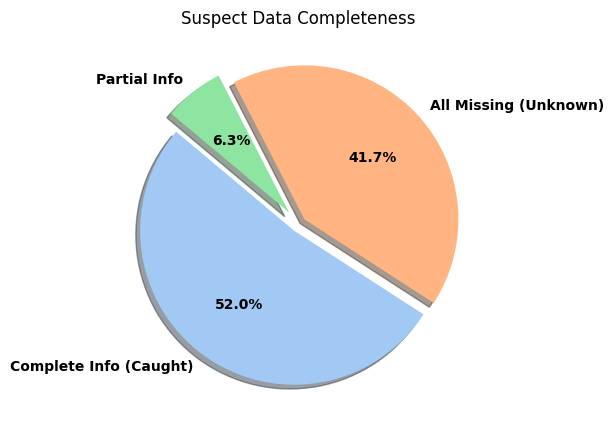

In [18]:
# 1. Define garbage values and columns
garbage = [np.nan, '(null)', 'UNKNOWN', 'U', '1020', '940', '224', '2021', '1022']
cols = ['PERP_SEX', 'PERP_RACE', 'PERP_AGE_GROUP']

# 2. Calculate missing values
missing_counts = raw_data[cols].isin(garbage) | raw_data[cols].isnull()
row_missing_sum = missing_counts.sum(axis=1)

# 3. Classify into categories
conditions = [
    (row_missing_sum == 0),  # All complete
    (row_missing_sum == 3),  # All missing
    (row_missing_sum > 0) & (row_missing_sum < 3) # Partial
]
labels = ['Complete Info (Caught)', 'All Missing (Unknown)', 'Partial Info']

# Temporary creation
raw_data['data_quality'] = np.select(conditions, labels, default='Other')

# 4. Prepare data
quality_counts = raw_data['data_quality'].value_counts()
ordered_counts = quality_counts.reindex(labels)

# 5. Create pie chart (Reduced size here)
plt.figure(figsize=(5, 5)) # <--- Change: size 5 by 5
colors = sns.color_palette('pastel')[0:3]
explode = (0.05, 0.05, 0.1)

plt.pie(ordered_counts, 
        labels=ordered_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 10, 'weight': 'bold'}) # Reduced font size slightly as well

plt.title('Suspect Data Completeness', fontsize=12)
plt.show()

# Cleanup
raw_data.drop(columns=['data_quality'], inplace=True)

##### 📊 Analysis: Structural Missingness Verification

**Observation:**
The pie chart confirms an "All or Nothing" pattern. **41.7%** of incidents miss *all* suspect features (Sex, Race, Age) simultaneously, while only **6.3%** have partial information.

**Conclusion & Action:**
* **Validation:** The synchronized missingness confirms these are **unsolved cases** (suspect not apprehended), not random data errors.
* **Strategy:** We will **not drop** these rows, as removing ~48% of the data would introduce severe **survivorship bias** (training only on solved crimes).
* **Imputation:** All missing values will be mapped to a standardized **'Unknown'** category to preserve the "unsolved" signal for the model.

In [19]:
# Define perpetrator columns and values to replace
perp_cols = ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
garbage = ['(null)', 'UNKNOWN', 'U', '1020', '1028', '940', '224', '2021', np.nan]

# Perform cleaning in a quick operation chain:
# Convert to object -> Replace garbage -> Fill missing -> Convert to category
raw_data[perp_cols] = raw_data[perp_cols].astype('object').replace(garbage, 'Unknown').fillna('Unknown').astype('category')

print("✅ Perpetrator columns cleaned to 'Unknown'.")

✅ Perpetrator columns cleaned to 'Unknown'.


In [20]:
# 1. Victim Columns (using the existing variable name)
perp_cols = [
    'VIC_AGE_GROUP', 
    'VIC_SEX', 
    'VIC_RACE'
]

large_perp_cols = []

print("--- 🕵️ Inspecting PERPETRATOR Columns (<= 15 Values) ---")

for col in perp_cols:
    if col in raw_data.columns:
        unique_vals = raw_data[col].unique()
        n_unique = len(unique_vals)
        
        # Filter condition: only small groups
        if n_unique <= 15:
            print(f"\n🔹 Column: {col} ({n_unique} values)")
            
            # Sort and print
            try:
                sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
                print(f"   Values: {sorted_vals}")
            except:
                print(f"   Values: {unique_vals.tolist()}")
            
            # Check for missing values
            nans = raw_data[col].isnull().sum()
            if nans > 0:
                print(f"   ⚠️ Contains {nans} NANs")
            
            print("-" * 40)
            
        else:
            large_perp_cols.append(f"{col} ({n_unique} values)")

# Summary for handling in the next step
if large_perp_cols:
    print("\n" + "="*40)
    print("--- ⏳ Large Perp Columns Saved for Next Step ---")
    for col in large_perp_cols:
        print(f"🔸 {col}")
    print("="*40)
else:
    print("\n✅ All Perp columns were small enough to display.")

--- 🕵️ Inspecting PERPETRATOR Columns (<= 15 Values) ---

🔹 Column: VIC_AGE_GROUP (7 values)
   Values: ['1022', '18-24', '25-44', '45-64', '65+', '<18', 'UNKNOWN']
----------------------------------------

🔹 Column: VIC_SEX (3 values)
   Values: ['F', 'M', 'U']
----------------------------------------

🔹 Column: VIC_RACE (7 values)
   Values: ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC']
----------------------------------------

✅ All Perp columns were small enough to display.


In [21]:
# 1. Define victim columns
vic_cols = ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']

# 2. Specific garbage list for victims (based on your output)
# U = Abbreviation for Unknown
# 1022 = Unrealistic age
vic_garbage = ['U', '1022', 'UNKNOWN', '(null)'] 

print("--- 🚑 Standardizing Victim Data ---")

# 3. Efficient one-line cleaning
# Convert to object -> Replace garbage -> Fill missing (safety) -> Convert back to category
raw_data[vic_cols] = raw_data[vic_cols].astype('object').replace(vic_garbage, 'Unknown').fillna('Unknown').astype('category')

print("✅ Victim columns cleaned (U/1022 -> Unknown).")

--- 🚑 Standardizing Victim Data ---
✅ Victim columns cleaned (U/1022 -> Unknown).


##### 4.2.2 Victim Data Standardization
**Observation:**
In contrast to the suspect data, the **Victim data is highly complete** (since victims are usually identified at the scene). We observed no structural missingness, only minor data entry inconsistencies:
* `'U'` (Legacy code for Unknown).
* `'1022'` (Impossible age value).

**Action:**
We are performing a simple **technical cleanup** to map these specific artifacts to the standardized **'Unknown'** category.

In [22]:
target_cols = [
    'BORO',
    'LOC_OF_OCCUR_DESC',
    'LOC_CLASSFCTN_DESC',
    'LOCATION_DESC',
    'PRECINCT'
]

large_loc_cols = []

print("--- 🔍 Phase 1: Inspecting Location/Admin Columns (<= 15 Values) ---")

for col in target_cols:
    if col in raw_data.columns:
        unique_vals = raw_data[col].unique()
        n_unique = len(unique_vals)
        
        # Filter condition: only groups smaller than or equal to 15
        if n_unique <= 15:
            print(f"\n🔹 Column: {col} ({n_unique} values)")
            
            # Sort and print to clearly see the values
            try:
                sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
                print(f"   Values: {sorted_vals}")
            except:
                print(f"   Values: {unique_vals.tolist()}")
            
            # Check for missing values
            nans = raw_data[col].isnull().sum()
            if nans > 0:
                print(f"   ⚠️ Contains {nans} NANs")
            
            print("-" * 40)
            
        else:
            # Keep the large ones aside
            large_loc_cols.append(col) # keeping only the name so we can use it later

# Summary for handling in the next step
print("\n" + "="*40)
print("--- ⏳ Large Columns Saved for Next Step ---")
for col in large_loc_cols:
    print(f"🔸 {col}")
print("="*40)

--- 🔍 Phase 1: Inspecting Location/Admin Columns (<= 15 Values) ---

🔹 Column: BORO (5 values)
   Values: ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
----------------------------------------

🔹 Column: LOC_OF_OCCUR_DESC (3 values)
   Values: ['INSIDE', 'OUTSIDE', nan]
   ⚠️ Contains 25596 NANs
----------------------------------------

🔹 Column: LOC_CLASSFCTN_DESC (11 values)
   Values: ['(null)', 'COMMERCIAL', 'DWELLING', 'HOUSING', 'OTHER', 'PARKING LOT', 'PLAYGROUND', 'STREET', 'TRANSIT', 'VEHICLE', nan]
   ⚠️ Contains 25596 NANs
----------------------------------------

--- ⏳ Large Columns Saved for Next Step ---
🔸 LOCATION_DESC
🔸 PRECINCT


##### 4.2.3 Location Data Standardization
**Observation:**
* **`BORO`:** Clean and complete.
* **Location Descriptions (`LOC_OF_...`):** High missingness (~85%).

**Strategy:**
Despite the high percentage of missing values, we will **retain** these columns because the available data (e.g., distinguishing 'INSIDE' vs 'OUTSIDE') contains high predictive value for specific crime patterns. We will standardize all missing entries (`NaN`, `(null)`) to **'Unknown'**.

In [23]:
# 1. Define problematic columns (BORO is fine so we don't touch it)
loc_cols = ['LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC']
loc_garbage = ['(null)', np.nan]

print("--- 📍 Standardizing Location Descriptions ---")

# 2. Quick clean: Convert -> Replace -> Fill
raw_data[loc_cols] = raw_data[loc_cols].astype('object').replace(loc_garbage, 'Unknown').fillna('Unknown').astype('category')

print(f"✅ Location columns cleaned. Missing values mapped to 'Unknown'.")

--- 📍 Standardizing Location Descriptions ---
✅ Location columns cleaned. Missing values mapped to 'Unknown'.


In [24]:
# Setting to ensure the full list is displayed without truncation
pd.set_option('display.max_colwidth', None)

large_cols = ['LOCATION_DESC', 'PRECINCT']

print("--- 🔍 Inspecting Large Categories (Full List) ---")

for col in large_cols:
    if col in raw_data.columns:
        unique_vals = raw_data[col].unique()
        n_unique = len(unique_vals)
        
        print(f"\n🔹 Column: {col} ({n_unique} values)")
        
        # Sort and print the full list
        try:
            sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
            print(f"   Values: {sorted_vals}")
        except:
            print(f"   Values: {unique_vals.tolist()}")
            
        # Check for missing values
        nans = raw_data[col].isnull().sum()
        if nans > 0:
            print(f"   ⚠️ Contains {nans} NANs")
            
        print("-" * 50)

--- 🔍 Inspecting Large Categories (Full List) ---

🔹 Column: LOCATION_DESC (41 values)
   Values: ['(null)', 'ATM', 'BANK', 'BAR/NIGHT CLUB', 'BEAUTY/NAIL SALON', 'CANDY STORE', 'CHAIN STORE', 'CHECK CASH', 'CLOTHING BOUTIQUE', 'COMMERCIAL BLDG', 'DEPT STORE', 'DOCTOR/DENTIST', 'DRUG STORE', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'FAST FOOD', 'GAS STATION', 'GROCERY/BODEGA', 'GYM/FITNESS FACILITY', 'HOSPITAL', 'HOTEL/MOTEL', 'JEWELRY STORE', 'LIQUOR STORE', 'LOAN COMPANY', 'MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'NONE', 'PHOTO/COPY STORE', 'PVT HOUSE', 'RESTAURANT/DINER', 'SCHOOL', 'SHOE STORE', 'SMALL MERCHANT', 'SOCIAL CLUB/POLICY LOCATI', 'STORAGE FACILITY', 'STORE UNCLASSIFIED', 'SUPERMARKET', 'TELECOMM. STORE', 'VARIETY STORE', 'VIDEO STORE', nan]
   ⚠️ Contains 14977 NANs
--------------------------------------------------

🔹 Column: PRECINCT (77 values)
   Values: [1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121

##### 4.2.4 Final Large Category Standardization
**Observation:**
* **`PRECINCT`:** Validated. Contains 77 unique police precinct codes with no missing values or zeros.
* **`LOCATION_DESC`:** Contains valuable specific details (e.g., 'BAR/NIGHT CLUB'), but ~50% of the data is missing or labeled as 'NONE'/'(null)'.

**Action:**
* **`PRECINCT`:** Keep as is (ensure categorical type).
* **`LOCATION_DESC`:** Standardize `NaN`, `(null)`, and `NONE` to **'Unknown'** to retain the 50% of high-quality location labels.

In [25]:
# 1. Handling LOCATION_DESC
# Added 'NONE' to the garbage list (in addition to null and NaN)
loc_desc_garbage = ['(null)', 'NONE', np.nan]

print("--- 🏢 Standardizing Specific Location Description ---")

# Convert -> Replace -> Fill -> Category
raw_data['LOCATION_DESC'] = raw_data['LOCATION_DESC'].astype('object').replace(loc_desc_garbage, 'Unknown').fillna('Unknown').astype('category')
print(f"✅ LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.")

# 2. Verify that PRECINCT is a category (and not a number)
# This is important because precinct 100 is not "2x" precinct 50, it is just a station name
raw_data['PRECINCT'] = raw_data['PRECINCT'].astype('category')
print(f"✅ PRECINCT validated and set to Category type.")

print("\n All Data Logic & Sanitation Checks Passed.")

--- 🏢 Standardizing Specific Location Description ---
✅ LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.
✅ PRECINCT validated and set to Category type.

 All Data Logic & Sanitation Checks Passed.


##### Feature Engineering: Semantic Grouping

In [26]:
# רשימת העמודות שאנחנו רוצים לבדוק לפני איחוד
cols_to_check = [
    'PERP_RACE', 
    'VIC_RACE',
    'LOC_CLASSFCTN_DESC',
    'LOCATION_DESC'
]

print("--- 📊 Frequency Check for Grouping Strategy ---")

for col in cols_to_check:
    if col in raw_data.columns:
        print(f"\n🔹 Column: {col}")
        
        # ספירת מופעים
        counts = raw_data[col].value_counts()
        
        # חישוב אחוזים
        percentages = raw_data[col].value_counts(normalize=True) * 100
        
        # חיבור לטבלה אחת ברורה
        summary = pd.concat([counts, percentages], axis=1, keys=['Count', 'Percent'])
        
        # הצגת הטבלה (אם היא ארוכה מדי, נציג את ה-20 הראשונים והזנב)
        if len(summary) > 20:
             print(summary.head(15))
             print("\n... (Tail of list) ...")
             print(summary.tail(5))
        else:
            print(summary)
            
        print("-" * 50)

--- 📊 Frequency Check for Grouping Strategy ---

🔹 Column: PERP_RACE
                                Count    Percent
PERP_RACE                                       
Unknown                         12776  42.953201
BLACK                           12323  41.430204
WHITE HISPANIC                   2667   8.966514
BLACK HISPANIC                   1487   4.999328
WHITE                             305   1.025417
ASIAN / PACIFIC ISLANDER          184   0.618612
AMERICAN INDIAN/ALASKAN NATIVE      2   0.006724
--------------------------------------------------

🔹 Column: VIC_RACE
                                Count    Percent
VIC_RACE                                        
BLACK                           20999  70.599112
WHITE HISPANIC                   4511  15.166084
BLACK HISPANIC                   2930   9.850726
WHITE                             741   2.491259
ASIAN / PACIFIC ISLANDER          478   1.607047
Unknown                            72   0.242066
AMERICAN INDIAN/ALASKAN NAT

In [27]:
# 1. מיפוי מדויק (39 ערכים)
groups = {
    'Residential': ['MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'PVT HOUSE', 'HOTEL/MOTEL'],
    
    'Food_Nightlife': ['BAR/NIGHT CLUB', 'LIQUOR STORE', 'SOCIAL CLUB/POLICY LOCATI', 'GROCERY/BODEGA', 
                       'RESTAURANT/DINER', 'FAST FOOD', 'SUPERMARKET'],
    
    'Public_Place': ['SCHOOL', 'HOSPITAL', 'BANK', 'ATM', 'DOCTOR/DENTIST', 'GYM/FITNESS FACILITY', 'GAS STATION'],
    
    'Commercial': ['STORE UNCLASSIFIED', 'CHAIN STORE', 'DEPT STORE', 'VARIETY STORE', 'SMALL MERCHANT',
                   'CLOTHING BOUTIQUE', 'SHOE STORE', 'JEWELRY STORE', 'BEAUTY/NAIL SALON', 'DRUG STORE',
                   'CANDY STORE', 'TELECOMM. STORE', 'VIDEO STORE', 'PHOTO/COPY STORE', 'CHECK CASH',
                   'LOAN COMPANY', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'COMMERCIAL BLDG', 'STORAGE FACILITY'],
    
    'Unknown': ['Unknown', '(null)', np.nan]
}

flat_map = {val: key for key, lst in groups.items() for val in lst}

print("--- 🔄 Feature Engineering: Exact Grouping ---")

# 2. ביצוע המיפוי למיקומים
raw_data['LOCATION_GROUP'] = raw_data['LOCATION_DESC'].map(flat_map).fillna('Unknown').astype('category')

# 3. ביצוע המיפוי לגזעים
raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(
    'AMERICAN INDIAN/ALASKAN NATIVE', 'Other').astype('category')

# בדיקה
print(raw_data['LOCATION_GROUP'].value_counts())

--- 🔄 Feature Engineering: Exact Grouping ---
LOCATION_GROUP
Unknown           17678
Residential        9278
Food_Nightlife     1954
Commercial          664
Public_Place        170
Name: count, dtype: int64


C:\Users\Adir\AppData\Local\Temp\ipykernel_20224\3919674125.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(


### 4.3 Feature Engineering: Semantic Grouping

**Strategy:**
To reduce noise and prevent overfitting (due to high cardinality), we mapped the 39 raw values of `LOCATION_DESC` into **5 robust semantic groups** based on environmental risk profiles:
* **Groups:** `Residential`, `Commercial`, `Food_Nightlife`, `Public_Place`, `Unknown`.

**Cleanup:**
Simultaneously, we merged negligible race categories (<0.1%) into **'Other'** to ensure all features have sufficient statistical weight for the models.

##### 4.3 Logic Validation - Numeric

In [28]:
raw_data.dtypes

OCCUR_DATE            datetime64[ns]
OCCUR_TIME                    object
BORO                        category
LOC_OF_OCCUR_DESC           category
PRECINCT                    category
JURISDICTION_CODE              Int64
LOC_CLASSFCTN_DESC          category
LOCATION_DESC               category
PERP_AGE_GROUP              category
PERP_SEX                    category
PERP_RACE                   category
VIC_AGE_GROUP               category
VIC_SEX                     category
VIC_RACE                    category
Latitude                     float64
Longitude                    float64
is_murder                      int64
LOCATION_GROUP              category
dtype: object

In [29]:
# -------------------------------------------------------
# Cell: Sanity Check - Temporal Data Validity
# -------------------------------------------------------

print("--- Checking OCCUR_DATE Validity ---")
# 1. Check Date Range
min_date = raw_data['OCCUR_DATE'].min()
max_date = raw_data['OCCUR_DATE'].max()

print(f"Earliest Date in dataset: {min_date}")
print(f"Latest Date in dataset:   {max_date}")

# Logic Validation: Ensure no future dates
if max_date > pd.Timestamp.now():
    print("⚠️ WARNING: Future dates detected! Check your data source.")
else:
    print("✅ Date range is logical (No future dates).")

print("\n--- Checking OCCUR_TIME Validity ---")
# 2. Check Time Logic
# Assuming OCCUR_TIME is string/object (e.g., '14:30:00')
# We check the lexicographical min/max to ensure they are within '00:00:00' and '23:59:59'
min_time = raw_data['OCCUR_TIME'].min()
max_time = raw_data['OCCUR_TIME'].max()

print(f"Earliest Time recorded: {min_time}")
print(f"Latest Time recorded:   {max_time}")

# Quick check for invalid time strings (like '24:00' or empty)
# Converting to datetime temporarily to catch format errors
try:
    temp_times = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce')
    invalid_times = temp_times.isna().sum()
    if invalid_times == 0:
        print("✅ All time values are in valid HH:MM:SS format.")
    else:
        print(f"⚠️ WARNING: Found {invalid_times} invalid time values (NaN after conversion).")
except Exception as e:
    print(f"⚠️ Error checking time format: {e}")

--- Checking OCCUR_DATE Validity ---
Earliest Date in dataset: 2006-01-01 00:00:00
Latest Date in dataset:   2024-12-31 00:00:00
✅ Date range is logical (No future dates).

--- Checking OCCUR_TIME Validity ---
Earliest Time recorded: 00:00:00
Latest Time recorded:   23:59:00
✅ All time values are in valid HH:MM:SS format.


### 4.4 Data Integrity Check: Jurisdiction & Coordinates

**Objective:**
To validate that logical/numerical columns contain expected values before proceeding to modeling.

**Checks:**
1.  **Jurisdiction Code:** Verify it contains only the 3 known legal jurisdictions (0=Patrol, 1=Transit, 2=Housing).
2.  **Target Variable (`is_murder`):** Confirm binary distribution (True/False).
3.  **Geo-Spatial Data:** Validate that Latitude/Longitude values fall within the valid range of New York City boundaries.

In [30]:
import pandas as pd

print("--- ⚖️ Categorical/Discrete Validity Check ---")

# 1. בדיקת קודי שיפוט (צריכים להיות 0, 1, 2)
# 0 = Patrol (סיור רגיל), 1 = Transit (משטרת תנועה/רכבת), 2 = Housing (דיור ציבורי)
print("\n🔹 JURISDICTION_CODE :")
print(raw_data['JURISDICTION_CODE'].value_counts(dropna=False).sort_index())

# 2. בדיקת עמודת המטרה (האם היה רצח)
print("\n🔹 is_murder (Expect True/False):")
print(raw_data['is_murder'].value_counts(dropna=False))

print("\n" + "="*40)
print("--- 🌐 Geo-Spatial Range Check (Float) ---")

# 3. בדיקת טווחים לקואורדינטות
# גבולות ניו יורק בגדול: Lat (40.4 - 40.9), Lon (-74.3 - -73.6)
geo_stats = raw_data[['Latitude', 'Longitude']].describe().loc[['min', 'max', 'mean', 'std']]
print(geo_stats)

# בדיקה לוגית מהירה
lat_valid = (geo_stats.loc['min', 'Latitude'] > 40) and (geo_stats.loc['max', 'Latitude'] < 41)
lon_valid = (geo_stats.loc['min', 'Longitude'] > -75) and (geo_stats.loc['max', 'Longitude'] < -73)

if lat_valid and lon_valid:
    print("\n✅ Coordinates are within valid NYC range.")
else:
    print("\n⚠️ WARNING: Coordinates might be out of range!")

--- ⚖️ Categorical/Discrete Validity Check ---

🔹 JURISDICTION_CODE :
JURISDICTION_CODE
0       24957
1         109
2        4676
<NA>        2
Name: count, dtype: Int64

🔹 is_murder (Expect True/False):
is_murder
0    23979
1     5765
Name: count, dtype: int64

--- 🌐 Geo-Spatial Range Check (Float) ---
       Latitude  Longitude
min   40.511586 -74.249303
max   40.910818 -73.702046
mean  40.739505 -73.909032
std    0.087655   0.065681

✅ Coordinates are within valid NYC range.


In [31]:
# 1. בדיקה מהו הערך השכיח (בדרך כלל 0)
mode_val = raw_data['JURISDICTION_CODE'].mode()[0]
print(f"Most frequent value (Mode): {mode_val}")

# 2. מילוי ה-NaN בערך השכיח והמרה ל-int (כדי להיפטר מהנקודה העשרונית)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].fillna(mode_val).astype(int)

# 3. המרה לקטגוריה (כפי שתכננו למשתנים בדידים)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('category')

print(f"✅ JURISDICTION_CODE cleaned. Filled 2 NaNs with '{mode_val}'.")
print("\nUnique Values Check (Should be 0, 1, 2):")
print(raw_data['JURISDICTION_CODE'].value_counts())

Most frequent value (Mode): 0
✅ JURISDICTION_CODE cleaned. Filled 2 NaNs with '0'.

Unique Values Check (Should be 0, 1, 2):
JURISDICTION_CODE
0    24959
2     4676
1      109
Name: count, dtype: int64


### 5. Pre-Split Feature Engineering (Row-Level)

In [32]:
# 1. Extract Date-Based Features
if 'OCCUR_DATE' in raw_data.columns:
    # Numeric month (1-12) for seasonality
    raw_data['Month'] = raw_data['OCCUR_DATE'].dt.month
    # Day name (Monday, Tuesday...) for categorical analysis
    raw_data['DayOfWeek'] = raw_data['OCCUR_DATE'].dt.day_name()

# 2. Extract Time-Based Features
if 'OCCUR_TIME' in raw_data.columns:
    # Extract Hour (0-23)
    raw_data['Hour'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce').dt.hour

# 3. Create Aggregated Features

# A. Part of Day Buckets
def get_part_of_day(h):
    if pd.isna(h): return 'Unknown'
    h = int(h)
    if 5 <= h < 12: return 'Morning'
    elif 12 <= h < 17: return 'Afternoon'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

if 'Hour' in raw_data.columns:
    raw_data['Part_of_Day'] = raw_data['Hour'].apply(get_part_of_day)

# B. Weekend Flag
if 'DayOfWeek' in raw_data.columns:
    weekend_days = ['Friday', 'Saturday', 'Sunday']
    raw_data['is_weekend'] = raw_data['DayOfWeek'].isin(weekend_days).astype(int)

# C. Holiday Features
# Initialize US Holidays for NY
us_holidays = holidays.US(subdiv='NY')

def get_holiday_name(date_obj):
    return us_holidays.get(date_obj)

# Create holiday columns
raw_data['holiday_name'] = raw_data['OCCUR_DATE'].apply(get_holiday_name)
raw_data['holiday_name'] = raw_data['holiday_name'].fillna('Not Holiday')
raw_data['is_holiday'] = (raw_data['holiday_name'] != 'Not Holiday').astype(int)

# D. Season Features (NYC Meteorological Seasons)
if 'Month' in raw_data.columns:
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'

    raw_data['Season'] = raw_data['Month'].apply(get_season)

print("Feature Engineering completed.")

# -------------------------------------------------------
# 4. Final Verification Table (Source vs. New Columns)
# -------------------------------------------------------
raw_data[['OCCUR_DATE', 'OCCUR_TIME', 'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 'is_weekend',
           'is_holiday', 'holiday_name', 'Season']].head(3)

Feature Engineering completed.


,OCCUR_DATE,OCCUR_TIME,Month,DayOfWeek,Hour,Part_of_Day,is_weekend,is_holiday,holiday_name,Season
0,2021-08-09,01:06:00,8,Monday,1,Night,0,0,Not Holiday,Summer
1,2018-04-07,19:48:00,4,Saturday,19,Evening,1,0,Not Holiday,Spring
2,2022-12-02,22:57:00,12,Friday,22,Evening,1,0,Not Holiday,Winter
